In [68]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from numpy import log
import time
from keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.layers import Dense, LeakyReLU
from keras.activations import elu
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LeakyReLU, ELU
# from arch import arch_model
from sklearn.preprocessing import StandardScaler
from keras.layers import GRU, Dense, Dropout
#importing necessary libraries
from math import log, exp
from datetime import datetime
from numpy import log, exp


In [69]:
class EuropeanOptionBS:
    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()

    def d1(self):
        d1 = (math.log(self.S / self.K) +
              (self.r - self.q + 0.5 * (self.sigma ** 2)) * self.T) / \
             (self.sigma * math.sqrt(self.T))
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * math.sqrt(self.T)
        return d2

    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) - \
                    self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) - \
                    self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return price

# real data

In [70]:


# Function to process AAPL CSV data (adapted from original data_cleaning function)
def data_cleaning_aapl(df_subset, maturity_date):
    """
    Clean and process AAPL options data subset.
    Adapted from original data_cleaning() function to work with AAPL CSV format.
    Follows exact same logic as original notebook.
    """
    df = df_subset.copy()
    
    # Step 1: Ensure column names are clean (already done in loading, but ensure)
    df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '')
    
    # Step 2: Rename columns to match expected format (same as original)
    # Original: {"Price~" : "underlying_stockprice", 'Last' : 'option_price'}
    columns = {
        "UNDERLYING_LAST": "underlying_stockprice",
        'C_LAST': 'option_price',
        'QUOTE_DATE': 'Time'
    }
    df.rename(columns=columns, inplace=True)
    
    # Step 3: Handle IV conversion (same as original)
    # Original: df[column_to_convert] = df[column_to_convert].str.rstrip('%').astype('float') / 100.0
    column_to_convert = 'C_IV'
    if column_to_convert in df.columns:
        # Remove rows with missing IV
        df = df[df[column_to_convert].notna()]
        df[column_to_convert] = df[column_to_convert].replace('', np.nan)
        df[column_to_convert] = pd.to_numeric(df[column_to_convert], errors='coerce')
        df = df[df[column_to_convert].notna()]
        df = df[df[column_to_convert] > 0]
        
        # Convert IV to decimal (same as original logic)
        if len(df) > 0 and df[column_to_convert].max() > 1:
            df[column_to_convert] = df[column_to_convert] / 100.0
        df.rename(columns={column_to_convert: 'IV'}, inplace=True)
    
    # Step 4: Convert Time to datetime (same as original: format='%m/%d/%Y')
    # AAPL format: '2022-07-01'
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df[df['Time'].notna()]
    
    # Step 5: Convert numeric columns
    df['underlying_stockprice'] = pd.to_numeric(df['underlying_stockprice'], errors='coerce')
    df['option_price'] = pd.to_numeric(df['option_price'], errors='coerce')
    df['Strike'] = pd.to_numeric(df['STRIKE'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['C_VOLUME'], errors='coerce')
    
    # Step 6: Drop unnecessary columns (same as original)
    for col in ['Open', 'High', 'Low', 'Change', '%Chg', 'Bid', 'Ask', 'Open Int', 'Delta', 
                'Gamma', 'Theta', 'Vega', 'Rho', 'Theo', 'STRIKE', 'C_VOLUME', 'QUOTE_DATE',
                'C_BID', 'C_ASK', 'P_BID', 'P_ASK', 'C_SIZE', 'P_SIZE']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    # Step 7: Sort by Time (same as original)
    df.sort_values(by='Time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Step 8: Basic filtering (same as original)
    df = df[df['underlying_stockprice'] > 0]
    r = 0.0516
    df['r'] = 0.0516
    
    # Step 9: Calculate Maturity (same as original: (maturity_date - df['Time']).dt.days / 252)
    df['Maturity'] = (maturity_date - df['Time']).dt.days 
    df['Maturity'] = df['Maturity'] / 252
    
    # Step 10: Feature Engineering (same as original)
    df['C/S'] = df['option_price'] / df['underlying_stockprice']
    df['Monyness'] = df['underlying_stockprice'] / df['Strike']
    df['K/S'] = df['Strike'] / df['underlying_stockprice']
    
    # Step 11: Data Filtering (same as original)
    df = df[df['Volume'] != 0]
    df = df[df['option_price'] != 0]
    df = df[df['option_price'] >= 0.1]
    df = df[df['Maturity'] <= 2.4]
    df = df[df['Maturity'] > 0]
    df = df.dropna()
    
    return df

In [71]:
# Load the AAPL CSV file (same as original notebook loads multiple CSVs)
print("Loading AAPL options data...")
df_raw = pd.read_csv('aapl_2021_2023.csv', low_memory=False)

# Strip brackets from column names
df_raw.columns = df_raw.columns.str.strip().str.replace('[', '').str.replace(']', '')

print(f"✓ Loaded {len(df_raw):,} rows")
print(f"✓ Date range: {df_raw['QUOTE_DATE'].min()} to {df_raw['QUOTE_DATE'].max()}")
print(f"✓ Columns: {len(df_raw.columns)}")

# Convert QUOTE_DATE to datetime for grouping
df_raw['QUOTE_DATE'] = pd.to_datetime(df_raw['QUOTE_DATE'], errors='coerce')
df_raw = df_raw[df_raw['QUOTE_DATE'].notna()]

# Group data by year-month (similar to original notebook's date groups)
# This mimics the original structure: 20240315, 20240419, 20240503, 20240517
df_raw['YearMonth'] = df_raw['QUOTE_DATE'].dt.to_period('M')

# Get unique year-months
unique_months = sorted(df_raw['YearMonth'].unique())
print(f"\n✓ Found {len(unique_months)} unique months")
print(f"✓ Sample months: {unique_months[:10]}")

# Use data spanning from late 2021 through early 2023 to match original's ~2 year span
# Original notebook shows data from Nov 2022 to July 2024 (~20 months)
# We'll use Nov 2021 through Mar 2023 (~17 months) to get similar time coverage
start_date = pd.Timestamp('2021-11-01')
end_date = pd.Timestamp('2023-03-31')

df_raw_filtered = df_raw[
    (df_raw['QUOTE_DATE'] >= start_date) & 
    (df_raw['QUOTE_DATE'] <= end_date)
].copy()

unique_months_filtered = sorted(df_raw_filtered['YearMonth'].unique())
print(f"\n✓ Filtered data: {len(df_raw_filtered):,} rows across {len(unique_months_filtered)} months")
print(f"✓ Date range: {df_raw_filtered['QUOTE_DATE'].min()} to {df_raw_filtered['QUOTE_DATE'].max()}")
print(f"✓ Available months: {unique_months_filtered}")


Loading AAPL options data...
✓ Loaded 548,163 rows
✓ Date range:  2021-01-04 to  2023-03-31
✓ Columns: 33

✓ Found 27 unique months
✓ Sample months: [Period('2021-01', 'M'), Period('2021-02', 'M'), Period('2021-03', 'M'), Period('2021-04', 'M'), Period('2021-05', 'M'), Period('2021-06', 'M'), Period('2021-07', 'M'), Period('2021-08', 'M'), Period('2021-09', 'M'), Period('2021-10', 'M')]

✓ Filtered data: 346,881 rows across 17 months
✓ Date range: 2021-11-01 00:00:00 to 2023-03-31 00:00:00
✓ Available months: [Period('2021-11', 'M'), Period('2021-12', 'M'), Period('2022-01', 'M'), Period('2022-02', 'M'), Period('2022-03', 'M'), Period('2022-04', 'M'), Period('2022-05', 'M'), Period('2022-06', 'M'), Period('2022-07', 'M'), Period('2022-08', 'M'), Period('2022-09', 'M'), Period('2022-10', 'M'), Period('2022-11', 'M'), Period('2022-12', 'M'), Period('2023-01', 'M'), Period('2023-02', 'M'), Period('2023-03', 'M')]


In [72]:
# Process data by month groups (similar to original notebook's date groups)
# We'll use the last day of each month as maturity_date (or use EXPIRE_DATE from data)

# Use ALL months in the filtered range to match original's longer time span
# This will give us ~17 months of data (Nov 2021 - Mar 2023) similar to original's ~20 months
selected_months = unique_months_filtered

print(f"Processing {len(selected_months)} month groups (spanning ~{len(selected_months)} months):")
for month in selected_months:
    print(f"  - {month}")

# Dictionary to hold processed DataFrames (like original: processed_2024419, etc.)
processed_groups = {}


Processing 17 month groups (spanning ~17 months):
  - 2021-11
  - 2021-12
  - 2022-01
  - 2022-02
  - 2022-03
  - 2022-04
  - 2022-05
  - 2022-06
  - 2022-07
  - 2022-08
  - 2022-09
  - 2022-10
  - 2022-11
  - 2022-12
  - 2023-01
  - 2023-02
  - 2023-03


In [73]:
# Process each month group (similar to original notebook's loop)
for month_period in selected_months:
    # Get data for this month from the filtered dataset
    month_data = df_raw_filtered[df_raw_filtered['YearMonth'] == month_period].copy()
    
    # Use the last day of the month as maturity_date (or could use max EXPIRE_DATE)
    # Convert Period to datetime for maturity_date calculation
    month_end = month_period.to_timestamp() + pd.offsets.MonthEnd(0)
    maturity_date = datetime(month_end.year, month_end.month, month_end.day)
    
    # Process this month's data
    print(f"\nProcessing {month_period} (maturity_date: {maturity_date.date()})...")
    processed_df = data_cleaning_aapl(month_data, maturity_date)
    
    # Store in dictionary (like original: processed_2024419[df_name])
    group_name = f"processed_{month_period.strftime('%Y%m')}"
    processed_groups[group_name] = processed_df
    
    print(f"  ✓ Processed {len(processed_df):,} rows")

print(f"\n✓ Total groups processed: {len(processed_groups)}")



Processing 2021-11 (maturity_date: 2021-11-30)...
  ✓ Processed 11,391 rows

Processing 2021-12 (maturity_date: 2021-12-31)...
  ✓ Processed 10,154 rows

Processing 2022-01 (maturity_date: 2022-01-31)...
  ✓ Processed 10,706 rows

Processing 2022-02 (maturity_date: 2022-02-28)...
  ✓ Processed 8,470 rows

Processing 2022-03 (maturity_date: 2022-03-31)...
  ✓ Processed 9,712 rows

Processing 2022-04 (maturity_date: 2022-04-30)...
  ✓ Processed 8,326 rows

Processing 2022-05 (maturity_date: 2022-05-31)...
  ✓ Processed 8,378 rows

Processing 2022-06 (maturity_date: 2022-06-30)...
  ✓ Processed 6,846 rows

Processing 2022-07 (maturity_date: 2022-07-31)...
  ✓ Processed 8,374 rows

Processing 2022-08 (maturity_date: 2022-08-31)...
  ✓ Processed 9,542 rows

Processing 2022-09 (maturity_date: 2022-09-30)...
  ✓ Processed 10,346 rows

Processing 2022-10 (maturity_date: 2022-10-31)...
  ✓ Processed 8,986 rows

Processing 2022-11 (maturity_date: 2022-11-30)...
  ✓ Processed 9,808 rows

Process

In [74]:
# Combine each group's DataFrames (similar to original: combined_df1, combined_df2, etc.)
# Since we have multiple groups, combine them similar to original notebook

combined_dfs = []
group_names = sorted(processed_groups.keys())

for i, group_name in enumerate(group_names, 1):
    if len(processed_groups[group_name]) > 0:
        combined_df = pd.concat([processed_groups[group_name]], ignore_index=True)
        combined_dfs.append(combined_df)
        print(f"combined_df{i} ({group_name}): {len(combined_df):,} rows")

# Final combination (like original: combined_df = pd.concat([combined_df1, combined_df2, combined_df3, combined_df4]))
if len(combined_dfs) > 0:
    combined_df = pd.concat(combined_dfs, ignore_index=True)
    print(f"\n✓ Final combined_df: {len(combined_df):,} rows")
    print(f"✓ Shape: {combined_df.shape}")
else:
    print("⚠ No data to combine!")
    combined_df = pd.DataFrame()


combined_df1 (processed_202111): 11,391 rows
combined_df2 (processed_202112): 10,154 rows
combined_df3 (processed_202201): 10,706 rows
combined_df4 (processed_202202): 8,470 rows
combined_df5 (processed_202203): 9,712 rows
combined_df6 (processed_202204): 8,326 rows
combined_df7 (processed_202205): 8,378 rows
combined_df8 (processed_202206): 6,846 rows
combined_df9 (processed_202207): 8,374 rows
combined_df10 (processed_202208): 9,542 rows
combined_df11 (processed_202209): 10,346 rows
combined_df12 (processed_202210): 8,986 rows
combined_df13 (processed_202211): 9,808 rows
combined_df14 (processed_202212): 10,202 rows
combined_df15 (processed_202301): 9,800 rows
combined_df16 (processed_202302): 8,728 rows
combined_df17 (processed_202303): 8,630 rows

✓ Final combined_df: 158,399 rows
✓ Shape: (158399, 33)


In [75]:
# Create final data variable (same as original: data = combined_df.copy())
if len(combined_df) > 0:
    data = combined_df.copy()
    
    # Sorting the combined DataFrame by 'Time' (same as original)
    data.sort_values(by='Time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print(f"✓ Final data: {len(data):,} rows")
    print(f"✓ Date range: {data['Time'].min()} to {data['Time'].max()}")
    print(f"✓ Columns: {data.columns.tolist()}")
else:
    data = pd.DataFrame()
    print("⚠ No data available!")


✓ Final data: 158,399 rows
✓ Date range: 2021-11-01 00:00:00 to 2023-03-30 00:00:00
✓ Columns: ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'Time', 'QUOTE_TIME_HOURS', 'underlying_stockprice', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'IV', 'option_price', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'YearMonth', 'Strike', 'Volume', 'r', 'Maturity', 'C/S', 'Monyness', 'K/S']


In [76]:
# Calculate log returns and GARCH conditional volatility (same as original notebook)
if len(data) > 0:
    # Calculate log returns properly - need to use unique dates only
    # Since multiple options can have the same date/stock price, we need to calculate
    # log returns on unique dates first, then merge back
    
    # Get unique dates and their stock prices
    unique_dates = data[['Time', 'underlying_stockprice']].drop_duplicates(subset=['Time'])
    unique_dates = unique_dates.sort_values(by='Time').reset_index(drop=True)
    
    # Calculate log returns on unique dates
    unique_dates['log_return'] = np.log(unique_dates['underlying_stockprice'] / unique_dates['underlying_stockprice'].shift(1))
    
    # Merge log returns back to original dataframe
    data = data.merge(unique_dates[['Time', 'log_return']], on='Time', how='left', suffixes=('', '_daily'))
    
    # Drop the old log_return column if it exists and rename the new one
    if 'log_return' in data.columns and 'log_return_daily' in data.columns:
        data = data.drop(columns=['log_return'])
        data = data.rename(columns={'log_return_daily': 'log_return'})
    elif 'log_return_daily' in data.columns:
        data = data.rename(columns={'log_return_daily': 'log_return'})
    
    # Drop rows where log_return is NaN (first row of each date group)
    data = data.dropna(subset=['log_return'])
    
    print(f"✓ Data after log return calculation: {len(data):,} rows")
    print(f"✓ Log return statistics:")
    print(data['log_return'].describe())
    
    # Fit a GARCH(1,1) model (same as original)
    try:
        from arch import arch_model
        # Use unique log returns for GARCH fitting (one per day)
        unique_returns = unique_dates['log_return'].dropna().values
        model = arch_model(unique_returns, vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp='off')
        
        # Create conditional volatility dataframe and merge back
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
        data = data.merge(cond_vol_df, on='Time', how='left')
        
        print("✓ GARCH conditional volatility calculated")
    except ImportError:
        print("⚠ GARCH library not installed - using IV as cond_vol")
        data['cond_vol'] = data['IV']
    except Exception as e:
        print(f"⚠ GARCH error: {e} - using IV as cond_vol")
        data['cond_vol'] = data['IV']
else:
    print("⚠ Cannot calculate log returns - no data")


✓ Data after log return calculation: 157,919 rows
✓ Log return statistics:
count    157919.000000
mean          0.000442
std           0.021600
min          -0.080232
25%          -0.012790
50%           0.000216
75%           0.015023
max           0.084146
Name: log_return, dtype: float64
⚠ GARCH library not installed - using IV as cond_vol


In [77]:
# Save to combine.csv (same as original notebook)
if len(data) > 0:
    data.to_csv('combine.csv', index=False)
    print(f"\n✓ SUCCESS! Data saved to combine.csv")
    print(f"✓ Final dataset: {len(data):,} rows, {len(data.columns)} columns")
    print(f"\n✓ Columns saved:")
    for i, col in enumerate(data.columns.tolist(), 1):
        print(f"  {i:2d}. {col}")
else:
    print("\n✗ ERROR: Cannot save - no data available!")



✓ SUCCESS! Data saved to combine.csv
✓ Final dataset: 157,919 rows, 35 columns

✓ Columns saved:
   1. QUOTE_UNIXTIME
   2. QUOTE_READTIME
   3. Time
   4. QUOTE_TIME_HOURS
   5. underlying_stockprice
   6. EXPIRE_DATE
   7. EXPIRE_UNIX
   8. DTE
   9. C_DELTA
  10. C_GAMMA
  11. C_VEGA
  12. C_THETA
  13. C_RHO
  14. IV
  15. option_price
  16. P_LAST
  17. P_DELTA
  18. P_GAMMA
  19. P_VEGA
  20. P_THETA
  21. P_RHO
  22. P_IV
  23. P_VOLUME
  24. STRIKE_DISTANCE
  25. STRIKE_DISTANCE_PCT
  26. YearMonth
  27. Strike
  28. Volume
  29. r
  30. Maturity
  31. C/S
  32. Monyness
  33. K/S
  34. log_return
  35. cond_vol


In [78]:
from IPython.display import display, Markdown

display(Markdown("```\n" + "="*60 + "\nDATA SUMMARY\n" + "="*60 + "\n```"))
display(Markdown(f"**Shape:** `{data.shape}`"))
display(data.head())
display(Markdown("**Null values per column:**"))
display(data.isnull().sum())

```
============================================================
DATA SUMMARY
============================================================
```

**Shape:** `(157919, 35)`

,QUOTE_UNIXTIME,QUOTE_READTIME,Time,QUOTE_TIME_HOURS,underlying_stockprice,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,YearMonth,Strike,Volume,r,Maturity,C/S,Monyness,K/S,log_return,cond_vol
480,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.94473,0.00788,...,2021-11,134.0,3.0,0.0516,0.111111,0.111667,1.119403,0.893333,0.006823,0.002719
481,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.94388,0.00898,...,2021-11,135.0,4.0,0.0516,0.111111,0.107133,1.111111,0.900000,0.006823,0.002564
482,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.92275,0.00035,...,2021-11,105.0,1.0,0.0516,0.111111,0.297933,1.428571,0.700000,0.006823,0.008363
483,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.92926,0.00046,...,2021-11,110.0,21.0,0.0516,0.111111,0.262667,1.363636,0.733333,0.006823,0.007110
484,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.93410,0.00070,...,2021-11,115.0,11.0,0.0516,0.111111,0.229333,1.304348,0.766667,0.006823,0.005975


**Null values per column:**

QUOTE_UNIXTIME           0
QUOTE_READTIME           0
Time                     0
QUOTE_TIME_HOURS         0
underlying_stockprice    0
EXPIRE_DATE              0
EXPIRE_UNIX              0
DTE                      0
C_DELTA                  0
C_GAMMA                  0
C_VEGA                   0
C_THETA                  0
C_RHO                    0
IV                       0
option_price             0
P_LAST                   0
P_DELTA                  0
P_GAMMA                  0
P_VEGA                   0
P_THETA                  0
P_RHO                    0
P_IV                     0
P_VOLUME                 0
STRIKE_DISTANCE          0
STRIKE_DISTANCE_PCT      0
YearMonth                0
Strike                   0
Volume                   0
r                        0
Maturity                 0
C/S                      0
Monyness                 0
K/S                      0
log_return               0
cond_vol                 0
dtype: int64

In [79]:
# Data processing complete - ready for model training!
# The 'data' variable contains the cleaned and combined dataset
# Same structure as original notebook's 'data' variable

In [80]:
# Verify final data structure matches original notebook expectations
if len(data) > 0:
    print("\n" + "="*60)
    print("FINAL DATA VERIFICATION")
    print("="*60)
    print(f"✓ Total rows: {len(data):,}")
    print(f"✓ Required columns present:")
    required_cols = ['Time', 'underlying_stockprice', 'option_price', 'Strike', 'IV', 'Volume', 
                     'Maturity', 'r', 'C/S', 'K/S', 'Monyness', 'log_return', 'cond_vol']
    for col in required_cols:
        status = "✓" if col in data.columns else "✗"
        print(f"  {status} {col}")
    print(f"\n✓ Data ready for model training!")
else:
    print("✗ No data available!")



FINAL DATA VERIFICATION
✓ Total rows: 157,919
✓ Required columns present:
  ✓ Time
  ✓ underlying_stockprice
  ✓ option_price
  ✓ Strike
  ✓ IV
  ✓ Volume
  ✓ Maturity
  ✓ r
  ✓ C/S
  ✓ K/S
  ✓ Monyness
  ✓ log_return
  ✓ cond_vol

✓ Data ready for model training!


### Exploratory data analysis (visualizations)

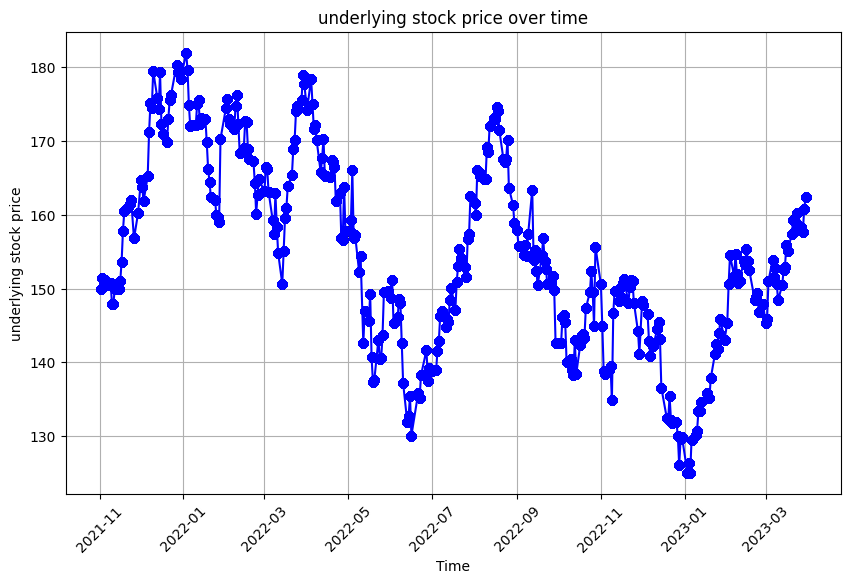

In [81]:
import matplotlib.pyplot as plt

# Plotting the underlying stock price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['underlying_stockprice'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('underlying stock price')
plt.title('underlying stock price over time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


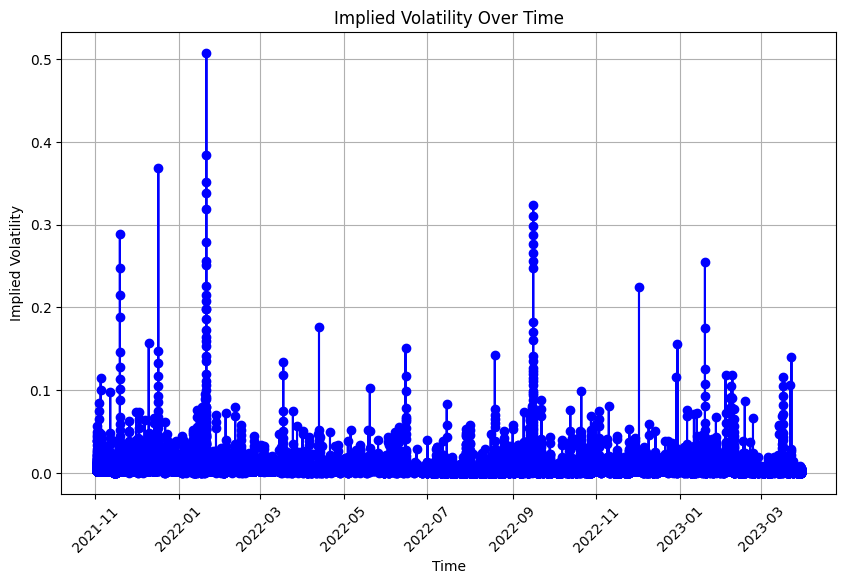

In [82]:
import matplotlib.pyplot as plt

# Plotting the Implied Volatility over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['IV'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


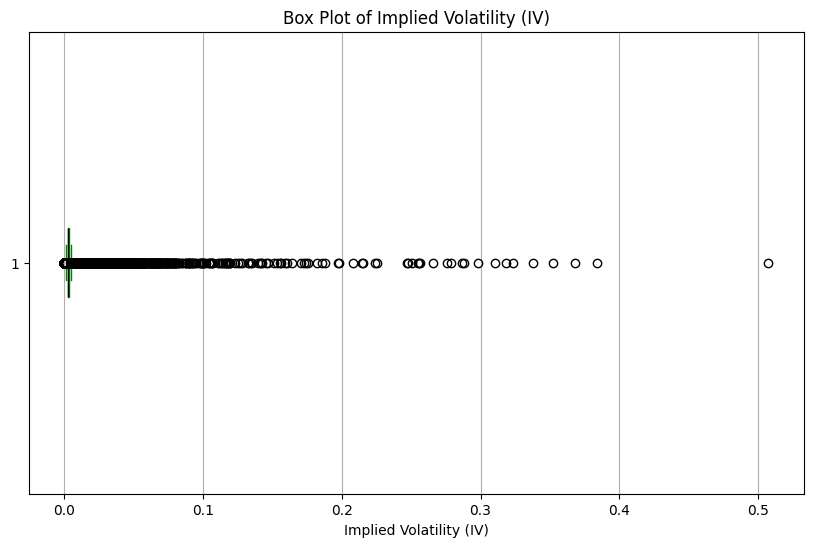

In [83]:
# Plotting a box plot for Implied Volatility (IV) to show its distribution
plt.figure(figsize=(10, 6))
plt.boxplot(data['IV'], vert=False, patch_artist=True, boxprops=dict(facecolor='g', color='g'), whiskerprops=dict(color='g'), capprops=dict(color='g'), medianprops=dict(color='black'))
plt.xlabel('Implied Volatility (IV)')
plt.title('Box Plot of Implied Volatility (IV)')
plt.grid(True, axis='x')
plt.show()


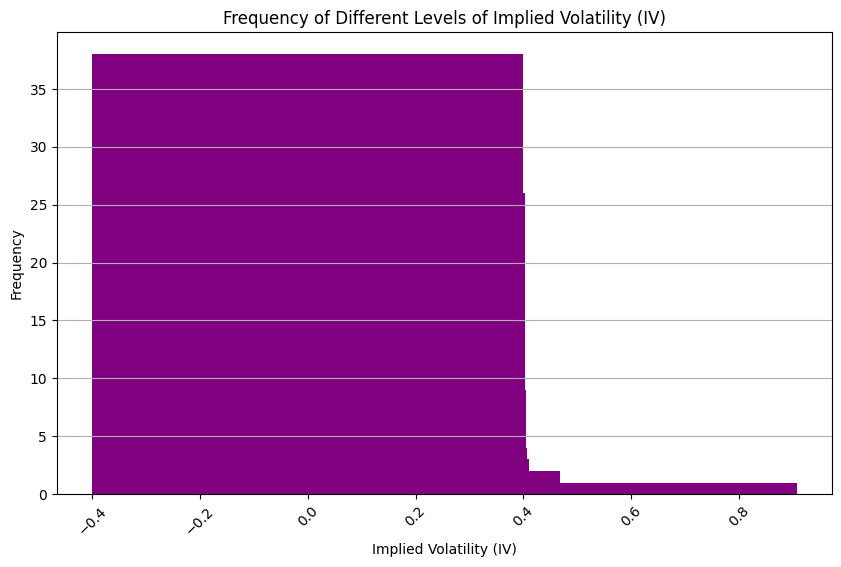

In [84]:
# Plotting a bar chart to show the frequency of different levels of Implied Volatility (IV)
plt.figure(figsize=(10, 6))
iv_counts = data['IV'].value_counts().sort_index()
plt.bar(iv_counts.index, iv_counts.values, color='purple')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Implied Volatility (IV)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


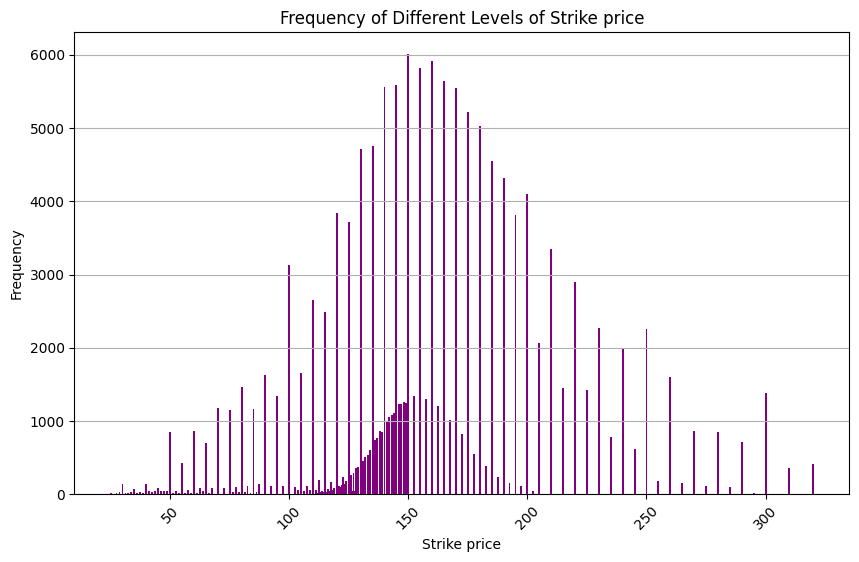

In [85]:
# Plotting a bar chart to show the frequency of different levels of Strike price
plt.figure(figsize=(10, 6))
strike_counts = data['Strike'].value_counts().sort_index()
plt.bar(strike_counts.index, strike_counts.values, color='purple')
plt.xlabel('Strike price')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Strike price')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


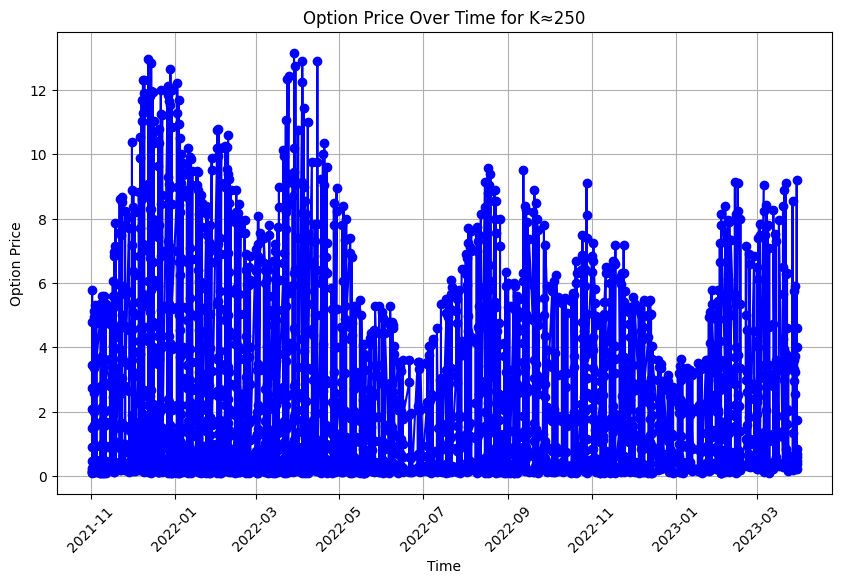

In [86]:
# Plotting Option Price Over Time for a specific strike price (K=250)
# Filter data for strike price closest to 250
if 'Strike' in data.columns:
    # Find strike prices close to 250
    strike_250_data = data[data['Strike'].between(245, 255)].copy()
    
    if len(strike_250_data) > 0:
        # Sort by Time for proper plotting
        strike_250_data = strike_250_data.sort_values(by='Time')
        
        plt.figure(figsize=(10, 6))
        plt.plot(strike_250_data['Time'], strike_250_data['option_price'], marker='o', linestyle='-', color='b')
        plt.xlabel('Time')
        plt.ylabel('Option Price')
        plt.title('Option Price Over Time for K≈250')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print("No data found for strike prices around 250")
else:
    print("Strike column not found in data")


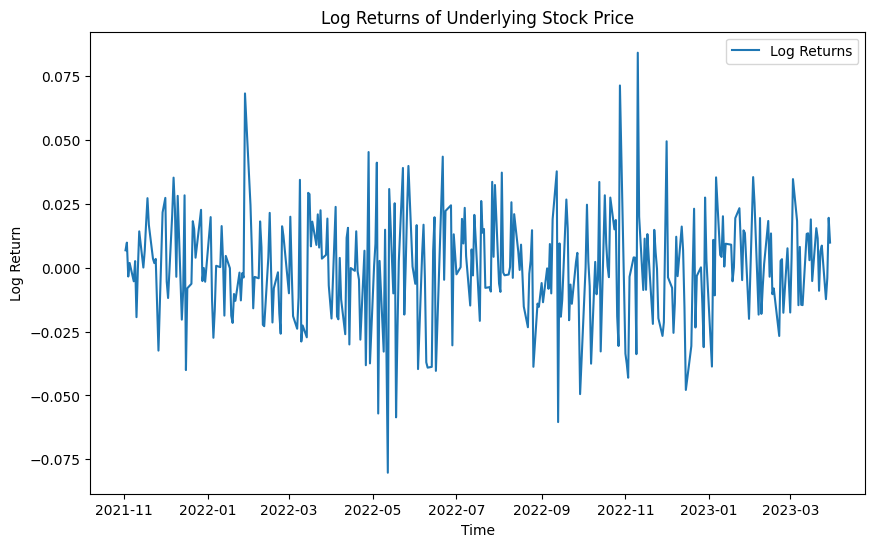

⚠ GARCH library (arch) not installed - using IV as cond_vol
Install with: pip install arch


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate log returns of the underlying stock prices (if not already calculated)
# Use the same corrected logic as Cell 9 to handle multiple rows per date
if 'log_return' not in data.columns:
    # Get unique dates and their stock prices
    unique_dates = data[['Time', 'underlying_stockprice']].drop_duplicates(subset=['Time'])
    unique_dates = unique_dates.sort_values(by='Time').reset_index(drop=True)
    
    # Calculate log returns on unique dates
    unique_dates['log_return'] = np.log(unique_dates['underlying_stockprice'] / unique_dates['underlying_stockprice'].shift(1))
    
    # Merge log returns back to original dataframe
    data = data.merge(unique_dates[['Time', 'log_return']], on='Time', how='left', suffixes=('', '_daily'))
    
    # Drop the old log_return column if it exists and rename the new one
    if 'log_return' in data.columns and 'log_return_daily' in data.columns:
        data = data.drop(columns=['log_return'])
        data = data.rename(columns={'log_return_daily': 'log_return'})
    elif 'log_return_daily' in data.columns:
        data = data.rename(columns={'log_return_daily': 'log_return'})
    
    # Drop rows where log_return is NaN (first row of each date group)
    data = data.dropna(subset=['log_return'])

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['log_return'], label='Log Returns')
plt.title('Log Returns of Underlying Stock Price')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# Fit a GARCH(1,1) model
try:
    from arch import arch_model
    # Use unique log returns for GARCH fitting (one per day) if available
    if 'unique_dates' in locals():
        unique_returns = unique_dates['log_return'].dropna().values
    else:
        # Fallback: get unique returns from data
        unique_dates_viz = data[['Time', 'log_return']].drop_duplicates(subset=['Time'])
        unique_returns = unique_dates_viz['log_return'].dropna().values
    
    model = arch_model(unique_returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')
    
    # Create conditional volatility dataframe and merge back
    if 'unique_dates' in locals():
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
    else:
        cond_vol_df = pd.DataFrame({
            'Time': unique_dates_viz['Time'].values,
            'cond_vol': garch_fit.conditional_volatility
        })
    data = data.merge(cond_vol_df, on='Time', how='left')
    
    # Summarize the GARCH model fit
    print(garch_fit.summary())
    
except ImportError:
    print("⚠ GARCH library (arch) not installed - using IV as cond_vol")
    print("Install with: pip install arch")
    if 'cond_vol' not in data.columns:
        data['cond_vol'] = data['IV']
except Exception as e:
    print(f"⚠ GARCH model fitting error: {e}")
    print("Using IV as cond_vol")
    if 'cond_vol' not in data.columns:
        data['cond_vol'] = data['IV']


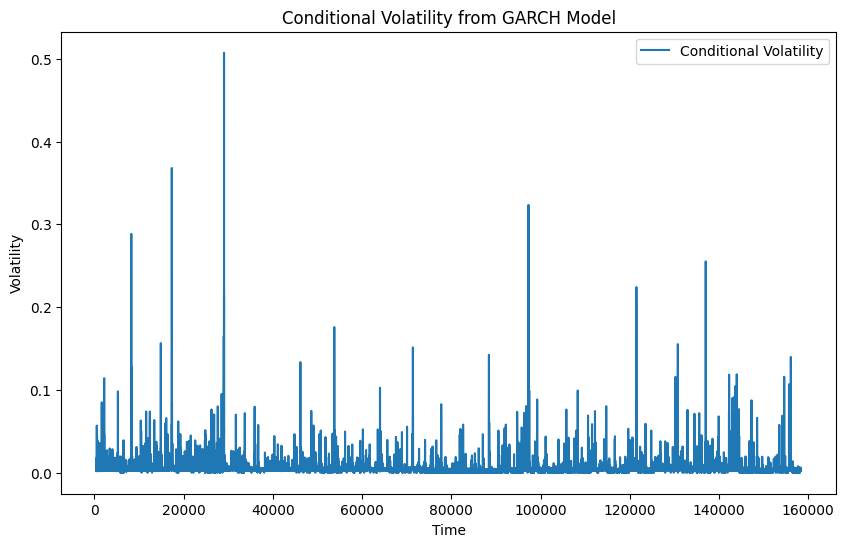

In [88]:
# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(data['cond_vol'], label='Conditional Volatility')
plt.title('Conditional Volatility from GARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## Machine Learning Models for Option Pricing

In this section, we implement three neural network architectures (MLP, LSTM, GRU) to predict option prices. We'll train models both with and without GARCH conditional volatility features to compare their performance.

### Overview
- **Target Variable**: `C/S` (Call option price / Stock price) - normalized for scale independence
- **Features**: `IV` (Implied Volatility), `K/S` (Strike/Stock ratio), `Maturity` (time to expiration), `r` (risk-free rate)
- **Optional Feature**: `cond_vol` (GARCH conditional volatility) - when available
- **Models**: MLP (Multi-Layer Perceptron), LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit)

In [ ]:
# Check data availability and columns
print(f"Data shape: {data.shape}")
print(f"\nAvailable columns:")
print(data.columns.tolist())
print(f"\nFirst few rows:")
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,Time,QUOTE_TIME_HOURS,underlying_stockprice,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,YearMonth,Strike,Volume,r,Maturity,C/S,Monyness,K/S,log_return,cond_vol
480,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.94473,0.00788,...,2021-11,134.0,3.0,0.0516,0.111111,0.111667,1.119403,0.893333,0.006823,0.002719
481,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.94388,0.00898,...,2021-11,135.0,4.0,0.0516,0.111111,0.107133,1.111111,0.900000,0.006823,0.002564
482,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.92275,0.00035,...,2021-11,105.0,1.0,0.0516,0.111111,0.297933,1.428571,0.700000,0.006823,0.008363
483,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.92926,0.00046,...,2021-11,110.0,21.0,0.0516,0.111111,0.262667,1.363636,0.733333,0.006823,0.007110
484,1635883200,2021-11-02 16:00,2021-11-02,16.0,150.0,2021-11-26,1637960400,24.04,0.93410,0.00070,...,2021-11,115.0,11.0,0.0516,0.111111,0.229333,1.304348,0.766667,0.006823,0.005975


In [ ]:
### Step 1: Feature Selection and Target Definition

We define our features and target variable. The target `C/S` represents the normalized option price, making it scale-independent and suitable for cross-asset comparison.


In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Check if cond_vol is available (from GARCH model)
use_garch = 'cond_vol' in data.columns and data['cond_vol'].notna().sum() > 0

# Define feature columns
if use_garch:
    feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
    print("✓ Using GARCH conditional volatility as additional feature")
else:
    feature_columns = ['IV', 'K/S', 'Maturity', 'r']
    print("⚠ GARCH not available - using IV only")

# Define target column
target_column = 'C/S'

print(f"\nFeatures: {feature_columns}")
print(f"Target: {target_column}")

# Check for missing values
print(f"\nMissing values check:")
print(data[feature_columns + [target_column]].isnull().sum())

# Remove rows with missing values
data_clean = data[feature_columns + [target_column]].dropna()
print(f"\n✓ Clean data: {len(data_clean):,} rows (removed {len(data) - len(data_clean):,} rows with missing values)")


### Step 2: Train-Test Split

We split the data into training (80%) and testing (20%) sets using a random seed for reproducibility.


In [ ]:
# Split the data into features and target
X = data_clean[feature_columns]
y = data_clean[target_column]

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(data_clean)*100:.1f}%)")
print(f"Testing set: {len(X_test):,} samples ({len(X_test)/len(data_clean)*100:.1f}%)")
print(f"\nTarget statistics (C/S):")
print(f"  Training - Mean: {y_train.mean():.6f}, Std: {y_train.std():.6f}")
print(f"  Testing  - Mean: {y_test.mean():.6f}, Std: {y_test.std():.6f}")


### Step 3: Data Scaling

We standardize the features using StandardScaler to ensure all features are on a similar scale, which helps neural networks converge faster and perform better.


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"  Scaled training shape: {X_train_scaled.shape}")
print(f"  Scaled testing shape: {X_test_scaled.shape}")

# Reshape data for LSTM/GRU (requires 3D: samples, timesteps, features)
# For time series, we use 1 timestep per sample
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"\n✓ Reshaped for LSTM/GRU:")
print(f"  LSTM training shape: {X_train_lstm.shape}")
print(f"  LSTM testing shape: {X_test_lstm.shape}")


### Step 4: Model Architecture Definitions

We define three neural network architectures:
1. **MLP**: Feedforward network with dense layers
2. **LSTM**: Long Short-Term Memory network for sequential patterns
3. **GRU**: Gated Recurrent Unit, similar to LSTM but computationally more efficient


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam

# Get input dimension
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim} features")

def create_mlp_model():
    """Create Multi-Layer Perceptron (MLP) model"""
    model = Sequential([
        Dense(units=100, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(units=50, activation='relu'),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def create_lstm_model():
    """Create LSTM model"""
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(1, input_dim)),
        LSTM(units=100, return_sequences=False),
        Dropout(0.3),
        Dense(units=50, activation='elu'),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def create_gru_model():
    """Create GRU model"""
    model = Sequential([
        GRU(units=100, return_sequences=True, input_shape=(1, input_dim)),
        GRU(units=100, return_sequences=False),
        Dropout(0.3),
        Dense(units=50, activation='elu'),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

print("✓ Model architectures defined")


### Step 5: Model Training

We train all three models and track their training time and loss.


In [ ]:
# Train MLP Model
print("=" * 60)
print("Training MLP Model...")
print("=" * 60)

mlp_model = create_mlp_model()
mlp_start_time = time.time()
mlp_history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_split=0.1
)
mlp_end_time = time.time()
mlp_training_time = mlp_end_time - mlp_start_time

print(f"✓ MLP training completed in {mlp_training_time:.2f} seconds")
print(f"  Final training loss: {mlp_history.history['loss'][-1]:.10f}")
if 'val_loss' in mlp_history.history:
    print(f"  Final validation loss: {mlp_history.history['val_loss'][-1]:.10f}")


In [ ]:
# Train LSTM Model
print("=" * 60)
print("Training LSTM Model...")
print("=" * 60)

lstm_model = create_lstm_model()
lstm_start_time = time.time()
lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_split=0.1
)
lstm_end_time = time.time()
lstm_training_time = lstm_end_time - lstm_start_time

print(f"✓ LSTM training completed in {lstm_training_time:.2f} seconds")
print(f"  Final training loss: {lstm_history.history['loss'][-1]:.10f}")
if 'val_loss' in lstm_history.history:
    print(f"  Final validation loss: {lstm_history.history['val_loss'][-1]:.10f}")


In [ ]:
# Train GRU Model
print("=" * 60)
print("Training GRU Model...")
print("=" * 60)

gru_model = create_gru_model()
gru_start_time = time.time()
gru_history = gru_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_split=0.1
)
gru_end_time = time.time()
gru_training_time = gru_end_time - gru_start_time

print(f"✓ GRU training completed in {gru_training_time:.2f} seconds")
print(f"  Final training loss: {gru_history.history['loss'][-1]:.10f}")
if 'val_loss' in gru_history.history:
    print(f"  Final validation loss: {gru_history.history['val_loss'][-1]:.10f}")


### Step 6: Model Predictions

Generate predictions on the test set for all three models.


In [ ]:
# Generate predictions
print("Generating predictions...")

y_pred_mlp = mlp_model.predict(X_test_scaled, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0)
y_pred_gru = gru_model.predict(X_test_lstm, verbose=0)

# Flatten predictions for metrics calculation
y_pred_mlp = y_pred_mlp.flatten()
y_pred_lstm = y_pred_lstm.flatten()
y_pred_gru = y_pred_gru.flatten()

print("✓ Predictions generated for all models")


### Step 7: Model Evaluation

Calculate performance metrics: RMSE, MAE, MSE, and R² for each model.


In [ ]:
# Calculate metrics for MLP
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

# Calculate metrics for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# Calculate metrics for GRU
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

# Print results in a table format
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(f"{'Model':<10} {'RMSE':<15} {'MAE':<15} {'MSE':<15} {'R²':<15} {'Time (s)':<15}")
print("-" * 80)
print(f"{'MLP':<10} {rmse_mlp:<15.10f} {mae_mlp:<15.10f} {mse_mlp:<15.10f} {r2_mlp:<15.6f} {mlp_training_time:<15.2f}")
print(f"{'LSTM':<10} {rmse_lstm:<15.10f} {mae_lstm:<15.10f} {mse_lstm:<15.10f} {r2_lstm:<15.6f} {lstm_training_time:<15.2f}")
print(f"{'GRU':<10} {rmse_gru:<15.10f} {mae_gru:<15.10f} {mse_gru:<15.10f} {r2_gru:<15.6f} {gru_training_time:<15.2f}")
print("=" * 80)


### Step 8: Visualizations

Create comprehensive visualizations to evaluate model performance:
1. **Loss Curves**: Training loss over epochs
2. **Actual vs Predicted Scatter Plots**: Visual comparison of predictions
3. **Fraction Error Plots**: Relative prediction errors
4. **Difference Plots**: Absolute prediction errors


In [ ]:
# Plot 1: Loss Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MLP Loss
axes[0].plot(mlp_history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in mlp_history.history:
    axes[0].plot(mlp_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('MLP Loss Function', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM Loss
axes[1].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in lstm_history.history:
    axes[1].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('LSTM Loss Function', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# GRU Loss
axes[2].plot(gru_history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in gru_history.history:
    axes[2].plot(gru_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[2].set_xlabel('Epochs', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].set_title('GRU Loss Function', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Plot 2: Actual vs Predicted Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MLP
axes[0].scatter(y_test, y_pred_mlp, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual C/S', fontsize=12)
axes[0].set_ylabel('Predicted C/S', fontsize=12)
axes[0].set_title(f'MLP: Actual vs Predicted (R² = {r2_mlp:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM
axes[1].scatter(y_test, y_pred_lstm, alpha=0.5, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual C/S', fontsize=12)
axes[1].set_ylabel('Predicted C/S', fontsize=12)
axes[1].set_title(f'LSTM: Actual vs Predicted (R² = {r2_lstm:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# GRU
axes[2].scatter(y_test, y_pred_gru, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual C/S', fontsize=12)
axes[2].set_ylabel('Predicted C/S', fontsize=12)
axes[2].set_title(f'GRU: Actual vs Predicted (R² = {r2_gru:.4f})', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Plot 3: Fraction Error Plots
# Fraction error = (Predicted / Actual) - 1
# Shows relative prediction error: 0 = perfect, 0.1 = 10% overestimate, -0.1 = 10% underestimate

fractions_mlp = (y_pred_mlp / y_test.values) - 1
fractions_lstm = (y_pred_lstm / y_test.values) - 1
fractions_gru = (y_pred_gru / y_test.values) - 1

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MLP Fraction Errors
axes[0].scatter(range(len(fractions_mlp)), fractions_mlp, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Fraction Error (Predicted/Actual - 1)', fontsize=12)
axes[0].set_title('MLP: Fraction Error Plot', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-0.5, 0.5])  # Limit y-axis for better visualization

# LSTM Fraction Errors
axes[1].scatter(range(len(fractions_lstm)), fractions_lstm, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Fraction Error (Predicted/Actual - 1)', fontsize=12)
axes[1].set_title('LSTM: Fraction Error Plot', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-0.5, 0.5])

# GRU Fraction Errors
axes[2].scatter(range(len(fractions_gru)), fractions_gru, alpha=0.5, s=10)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Sample Index', fontsize=12)
axes[2].set_ylabel('Fraction Error (Predicted/Actual - 1)', fontsize=12)
axes[2].set_title('GRU: Fraction Error Plot', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.show()

# Print fraction error statistics
print("\nFraction Error Statistics:")
print("=" * 80)
print(f"{'Model':<10} {'Mean':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
print("-" * 80)
print(f"{'MLP':<10} {np.mean(fractions_mlp):<15.6f} {np.std(fractions_mlp):<15.6f} {np.min(fractions_mlp):<15.6f} {np.max(fractions_mlp):<15.6f}")
print(f"{'LSTM':<10} {np.mean(fractions_lstm):<15.6f} {np.std(fractions_lstm):<15.6f} {np.min(fractions_lstm):<15.6f} {np.max(fractions_lstm):<15.6f}")
print(f"{'GRU':<10} {np.mean(fractions_gru):<15.6f} {np.std(fractions_gru):<15.6f} {np.min(fractions_gru):<15.6f} {np.max(fractions_gru):<15.6f}")
print("=" * 80)


In [ ]:
# Plot 4: Fraction Errors vs Days to Maturity
# This helps identify if prediction errors vary with time to expiration

# Get maturity values for test set (need to align with test indices)
test_indices = y_test.index
maturity_test = data_clean.loc[test_indices, 'Maturity'].values * 252  # Convert to days

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MLP
axes[0].scatter(maturity_test, fractions_mlp, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Days to Maturity', fontsize=12)
axes[0].set_ylabel('Fraction Error', fontsize=12)
axes[0].set_title('MLP: Fraction Error vs Days to Maturity', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-0.5, 0.5])

# LSTM
axes[1].scatter(maturity_test, fractions_lstm, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Days to Maturity', fontsize=12)
axes[1].set_ylabel('Fraction Error', fontsize=12)
axes[1].set_title('LSTM: Fraction Error vs Days to Maturity', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-0.5, 0.5])

# GRU
axes[2].scatter(maturity_test, fractions_gru, alpha=0.5, s=10)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Days to Maturity', fontsize=12)
axes[2].set_ylabel('Fraction Error', fontsize=12)
axes[2].set_title('GRU: Fraction Error vs Days to Maturity', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.show()


In [ ]:
# Plot 5: Absolute Difference Plots
difference_mlp = y_test.values - y_pred_mlp
difference_lstm = y_test.values - y_pred_lstm
difference_gru = y_test.values - y_pred_gru

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MLP
axes[0].plot(difference_mlp, alpha=0.7, linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Difference (Actual - Predicted)', fontsize=12)
axes[0].set_title('MLP: Absolute Prediction Difference', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# LSTM
axes[1].plot(difference_lstm, alpha=0.7, linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Difference (Actual - Predicted)', fontsize=12)
axes[1].set_title('LSTM: Absolute Prediction Difference', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# GRU
axes[2].plot(difference_gru, alpha=0.7, linewidth=0.5)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Sample Index', fontsize=12)
axes[2].set_ylabel('Difference (Actual - Predicted)', fontsize=12)
axes[2].set_title('GRU: Absolute Prediction Difference', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Summary

The implementation includes:
- ✅ Feature selection and target definition (`C/S` ratio)
- ✅ Train-test split (80/20)
- ✅ Data scaling using StandardScaler
- ✅ Three model architectures (MLP, LSTM, GRU)
- ✅ Model training with loss tracking
- ✅ Comprehensive evaluation metrics (RMSE, MAE, MSE, R²)
- ✅ Multiple visualizations:
  - Loss curves during training
  - Actual vs Predicted scatter plots
  - Fraction error plots
  - Fraction errors vs Days to Maturity
  - Absolute difference plots

**Next Steps** (if needed):
- Experiment with different architectures and hyperparameters
- Implement models with GARCH conditional volatility when available
- Compare performance with and without GARCH features
- Implement ensemble methods
- Add cross-validation for more robust evaluation
